## Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
from fredapi import Fred
from dotenv import load_dotenv
import os
import json
from functools import reduce
import numpy as np


load_dotenv()

FRED_API_KEY = os.getenv("FRED_API_KEY")

fred = Fred(api_key=FRED_API_KEY)

## Helpers

In [2]:
def series_to_json(series, df):
    """
    Convert a FRED series to a JSON string.
    """
    path = f"datasets/fred_{series}.json"
    # If file exists, load and merge
    if os.path.exists(path):
        # Load existing data
        with open(path, "r") as f:
            existing_data = json.load(f)
        df_existing = pd.DataFrame(existing_data)
        df_existing["Date"] = pd.to_datetime(df_existing["Date"])

        # Append only new rows
        df_combined = pd.concat([df_existing, df])
        df_combined = df_combined.drop_duplicates(subset=["Date"]).sort_values("Date")
    else:
        # No file exists, use fresh data
        df_combined = df

    # Save to JSON
    df_combined.to_json(path, orient="records", date_format="iso")

    print(f"Updated data saved to {path}")


def merge_on_year(dfs, how='inner'):
    """
    Merge a list of dataframes on the 'Year' column.

    Parameters:
    dfs (list): List of pandas DataFrames, each with a 'Year' column.
    how (str): Type of merge - 'inner', 'outer', 'left', 'right'. Default 'inner'.

    Returns:
    DataFrame: Merged dataframe.
    """
    # Safety check: make sure they all have 'Year' column
    for i, df in enumerate(dfs):
        if 'Year' not in df.columns:
            raise ValueError(f"DataFrame at index {i} is missing 'Year' column.")

    merged_df = reduce(lambda left, right: pd.merge(left, right, on='Year', how=how), dfs)
    return merged_df


def calc_mtg_pi_payment(principal, annual_rate, years=30):
    """
    Calculate monthly principal & interest payment for a mortgage.

    principal: Loan amount
    annual_rate: Annual interest rate as a percentage (e.g., 6.5 for 6.5%)
    years: Term in years (default 30)
    """
    monthly_rate = (annual_rate / 100) / 12
    n_payments = years * 12
    
    if monthly_rate == 0:
        return principal / n_payments  # handle zero interest edge case
    
    payment = principal * (monthly_rate * (1 + monthly_rate) ** n_payments) / \
              ((1 + monthly_rate) ** n_payments - 1)
    return payment


def scale_for_inflation(cpi_df: pd.DataFrame, from_year: int, to_year: int, amount: float):
    from_year_cpi = cpi_df.loc[cpi_df['Year'] == from_year, 'CPI'].values[0]
    to_year_cpi = cpi_df.loc[cpi_df['Year'] == to_year, 'CPI'].values[0]
    adjusted_value = (amount * (to_year_cpi / from_year_cpi))
    
    return round(adjusted_value, 2)


## Affordability

### Producer Price Index by Industry: Premiums for Property and Casualty Insurance: Premiums for Homeowner's Insurance (PCU9241269241262)

In [3]:
cpi = fred.get_series('CPIAUCSL')
cpi_df = cpi.to_frame().reset_index()
cpi_df.columns = ['Date', 'CPI']
cpi_df['Date'] = pd.to_datetime(cpi_df['Date'])
cpi_df.set_index('Date', inplace=True)
cpi_df = cpi_df.resample('YE').max().round(2)
cpi_df.index = cpi_df.index.year
cpi_df.reset_index(inplace=True)
cpi_df.columns = ['Year', 'CPI']

cpi_df.tail()

,Year,CPI
74,2021,280.81
75,2022,298.81
76,2023,308.74
77,2024,317.60
78,2025,322.13


In [4]:
def get_home_affordability():
    hoi_ref_premium = 3303
    hoi_ref_year = 2024

    #CPI table - resampled to annual on mean
    cpi = fred.get_series('CPIAUCSL')
    cpi_df = cpi.to_frame().reset_index()
    cpi_df.columns = ['Date', 'CPI']
    cpi_df['Date'] = pd.to_datetime(cpi_df['Date'])
    cpi_df.set_index('Date', inplace=True)
    cpi_df = cpi_df.resample('YE').max()
    cpi_df.index = cpi_df.index.year
    cpi_df.reset_index(inplace=True)
    cpi_df.columns = ['Year', 'CPI']

    #HOI PPI table - resampled to annual on mean
    hoi_series = fred.get_series('PCU9241269241262')
    hoi_df = hoi_series.to_frame().reset_index()
    hoi_df.columns = ['Date', 'HOI PPI']
    hoi_df['Date'] = pd.to_datetime(hoi_df['Date'])
    hoi_df.set_index('Date', inplace=True)
    hoi_df = hoi_df.resample('YE').mean()
    hoi_df.index = hoi_df.index.year
    hoi_df.reset_index(inplace=True)
    hoi_df.columns = ['Year', 'HOI PPI']

    #Estimate HOI premiums based on reference year adjusted by PPI
    hoi_ref_cpi = hoi_df.loc[hoi_df['Year'] == hoi_ref_year, 'HOI PPI'].values[0]
    hoi_df['Est HOI Premium'] = (hoi_df['HOI PPI'] * (hoi_ref_premium / hoi_ref_cpi))

    #Merge the datasets
    merged_hoi_df = merge_on_year([hoi_df, cpi_df], how='outer')

    # anchor year where both PPI + Premium exist
    anchor_year = 1998
    premium_anchor = merged_hoi_df.loc[merged_hoi_df["Year"] == anchor_year, "Est HOI Premium"].values[0]
    cpi_anchor = merged_hoi_df.loc[merged_hoi_df["Year"] == anchor_year, "CPI"].values[0]

    # fill missing premiums before PPI begins
    mask = merged_hoi_df["Year"] < anchor_year
    merged_hoi_df.loc[mask, "Est HOI Premium"] = (
        premium_anchor * (merged_hoi_df.loc[mask, "CPI"] / cpi_anchor)
    )
    merged_hoi_df.loc[mask, "HOI PPI"] = np.nan
    # Add scaled premiums
    merged_hoi_df['Scaled Premium'] = merged_hoi_df.apply(lambda row: scale_for_inflation(cpi_df, 2024, row['Year'], row['Est HOI Premium']), axis=1)

    #Median Home Prices DF - resampled to annual as mean
    median_home_prices = fred.get_series('MSPUS')
    df_home_median_prices = median_home_prices.to_frame().reset_index()
    df_home_median_prices.columns = ['Date', 'Median Sales Price']
    df_home_median_prices['Date'] = pd.to_datetime(df_home_median_prices['Date'])
    df_home_median_prices.set_index('Date', inplace=True)
    df_home_median_prices_annual = df_home_median_prices.resample('YE').mean()
    df_home_median_prices_annual.index = df_home_median_prices_annual.index.year
    df_home_median_prices_annual.reset_index(inplace=True)
    df_home_median_prices_annual.columns = ['Year', 'Median Sales Price']

    #Median Family Income - annual series
    median_family_income = fred.get_series('MEFAINUSA646N')
    df_median_family_income =  median_family_income.to_frame().reset_index()
    df_median_family_income.columns = ['Date', 'Median Family Income']
    df_median_family_income['Date'] = pd.to_datetime(df_median_family_income['Date'])
    df_median_family_income.set_index('Date', inplace=True)
    df_median_family_income.index = df_median_family_income.index.year
    df_median_family_income.reset_index(inplace=True)
    df_median_family_income.columns = ['Year', 'Median Family Income']

    #30Yr Mortgage Rates - resampled to annual as mean
    mtg30 = fred.get_series('MORTGAGE30US')
    df_mtg30 = mtg30.to_frame().reset_index()
    df_mtg30.columns = ['Date', '30yr Mtg Rate']
    df_mtg30['Date'] = pd.to_datetime(df_mtg30['Date'])
    df_mtg30.set_index('Date', inplace=True)
    df_mtg30 = df_mtg30.resample('YE').mean()
    df_mtg30.index = df_mtg30.index.year
    df_mtg30.reset_index(inplace=True)
    df_mtg30.columns = ['Year', '30yr Mtg Rate']
    df_mtg30['30yr Mtg Rate'] = round(df_mtg30['30yr Mtg Rate'], 3)

    #Merge datasets and add customer features
    cdf = merge_on_year([merged_hoi_df, df_home_median_prices_annual, df_median_family_income, df_mtg30])
    cdf['Avg Loan Amount'] = cdf['Median Sales Price'] * .8
    cdf['Mtg PI Monthly'] = cdf.apply(lambda row: calc_mtg_pi_payment(row['Avg Loan Amount'], row['30yr Mtg Rate']), axis=1).round(2)
    cdf['Mtg PI Annual'] = cdf['Mtg PI Monthly'] * 12
    cdf['Mtg PII Annual'] = cdf['Mtg PI Annual'] + cdf['Scaled Premium']
    cdf['Mtg PII Monthly'] = round((cdf['Mtg PI Annual'] / 12) + (cdf['Scaled Premium'] / 12), 2)
    cdf['Mtg Ratio'] = cdf['Mtg PII Annual'] / cdf['Median Family Income']

    return cdf

cdf = get_home_affordability()
cdf.tail()

,Year,HOI PPI,Est HOI Premium,CPI,Scaled Premium,Median Sales Price,Median Family Income,30yr Mtg Rate,Avg Loan Amount,Mtg PI Monthly,Mtg PI Annual,Mtg PII Annual,Mtg PII Monthly,Mtg Ratio
48,2019,210.225000,2776.866054,258.630,2261.25,320250.0,86010.0,3.936,256200.0,1213.70,14564.40,16825.65,1402.14,0.195624
49,2020,213.350000,2818.144239,262.045,2325.17,328150.0,84350.0,3.112,262520.0,1122.72,13472.64,15797.81,1316.48,0.187289
50,2021,216.077167,2854.167436,280.806,2523.49,383000.0,88590.0,2.958,306400.0,1284.86,15418.32,17941.81,1495.15,0.202526
51,2022,218.355167,2884.257581,298.808,2713.57,432950.0,92750.0,5.344,346360.0,1932.83,23193.96,25907.53,2158.96,0.279326
52,2023,227.862750,3009.843432,308.735,2925.80,426525.0,100800.0,6.807,341220.0,2226.09,26713.08,29638.88,2469.91,0.294037


In [5]:
value = scale_for_inflation(cpi_df, 1976, 2025, 86.88)
value

np.float64(479.22)

### Median Home Prices

In [6]:
# Median Home Price
# Fred series MSPUS
median_home_prices = fred.get_series('MSPUS')
df_home_median_prices = median_home_prices.to_frame().reset_index()
df_home_median_prices.columns = ['Date', 'Median Sales Price']
df_home_median_prices['Date'] = pd.to_datetime(df_home_median_prices['Date'])
df_home_median_prices.set_index('Date', inplace=True)

df_home_median_prices_annual = df_home_median_prices.resample('YE').mean()
df_home_median_prices_annual.index = df_home_median_prices_annual.index.year
df_home_median_prices_annual.reset_index(inplace=True)
df_home_median_prices_annual.columns = ['Year', 'Median Sales Price']
df_home_median_prices_annual.tail()


,Year,Median Sales Price
58,2021,383000.0
59,2022,432950.0
60,2023,426525.0
61,2024,418975.0
62,2025,416950.0


### Median Family Income

In [7]:
# Median Family Income in the United States (MEFAINUSA646N)
median_family_income = fred.get_series('MEFAINUSA646N')
df_median_family_income =  median_family_income.to_frame().reset_index()
df_median_family_income.columns = ['Date', 'Median Family Income']
df_median_family_income['Date'] = pd.to_datetime(df_median_family_income['Date'])
df_median_family_income.set_index('Date', inplace=True)
df_median_family_income.index = df_median_family_income.index.year
df_median_family_income.reset_index(inplace=True)
df_median_family_income.columns = ['Year', 'Median Family Income']

### Mortgage Rate - 30 year

In [8]:
# 30 Year Mortgage Rate

mtg30 = fred.get_series('MORTGAGE30US')
df_mtg30 = mtg30.to_frame().reset_index()
df_mtg30.columns = ['Date', '30yr Mtg Rate']
df_mtg30['Date'] = pd.to_datetime(df_mtg30['Date'])
df_mtg30.set_index('Date', inplace=True)
df_mtg30 = df_mtg30.resample('YE').mean()
df_mtg30.index = df_mtg30.index.year
df_mtg30.reset_index(inplace=True)
df_mtg30.columns = ['Year', '30yr Mtg Rate']
df_mtg30['30yr Mtg Rate'] = round(df_mtg30['30yr Mtg Rate'], 3)

df_mtg30.tail()

,Year,30yr Mtg Rate
50,2021,2.958
51,2022,5.344
52,2023,6.807
53,2024,6.721
54,2025,6.770


In [9]:
cdf = merge_on_year([merged_hoi_df, df_home_median_prices_annual, df_median_family_income, df_mtg30])
cdf['Avg Loan Amount'] = cdf['Median Sales Price'] * .8
cdf['Mtg PI Annual'] = cdf.apply(lambda row: calc_mtg_pi_payment(row['Avg Loan Amount'] * 12, row['30yr Mtg Rate']), axis=1).round(2)
cdf['Mtg PII Annual'] = cdf['Mtg PI Annual'] + cdf['Scaled Premium']
cdf['Mtg PII Monthly'] = round((cdf['Mtg PI Annual'] / 12) + (cdf['Scaled Premium'] / 12), 2)
cdf['Mtg Ratio'] = cdf['Mtg PII Annual'] / cdf['Median Family Income']
cdf.tail(50)

NameError: name 'merged_hoi_df' is not defined

### US Population

In [10]:
pop = fred.get_series('POPTHM')
pop_df = pop.to_frame().reset_index()
pop_df.columns = ['Date', 'US Population']
pop_df['Date'] = pd.to_datetime(pop_df['Date'])
pop_df.set_index('Date', inplace=True)

pop_df = pop_df.resample('YE').max().round(0)
pop_df.index = pop_df.index.year
pop_df.reset_index(inplace=True)
pop_df.columns = ['Year', 'US Population']
pop_df['US Population'] = pop_df['US Population'] * 1000

pop_df.tail()

,Year,US Population
62,2021,333260000.0
63,2022,335604000.0
64,2023,338626000.0
65,2024,341320000.0
66,2025,342197000.0


### Median Personal Income

In [11]:
# Median Personal Income In the United States (MEPAINUSA646N)
median_pers_income = fred.get_series('MEPAINUSA646N')
df_median_pers_income = median_pers_income.to_frame().reset_index()
df_median_pers_income.columns = ['Date', 'Median Personal Income']
df_median_pers_income['Date'] = pd.to_datetime(df_median_pers_income['Date'])
df_median_pers_income.set_index('Date', inplace=True)
df_median_pers_income.index = df_median_pers_income.index.year
df_median_pers_income.reset_index(inplace=True)
df_median_pers_income.columns = ['Year', 'Median Personal Income']

df_median_pers_income.tail()

,Year,Median Personal Income
45,2019,35980.0
46,2020,35850.0
47,2021,37520.0
48,2022,40480.0
49,2023,42220.0


In [ ]:
# Mortgage Payment Burden

# Calc monthly P&I using MORTGAGE30US and 80% of median home price
# Calc monthly T&I using average homeowner's insurance and property taxes
# Annualize the monthly payment and divide by median income

### CPI (CPIAUCSL)

In [12]:
cpi = fred.get_series('CPIAUCSL')
cpi_df = cpi.to_frame().reset_index()
cpi_df.columns = ['Date', 'CPI']
cpi_df['Date'] = pd.to_datetime(cpi_df['Date'])
cpi_df.set_index('Date', inplace=True)
cpi_df = cpi_df.resample('YE').max()
cpi_df.index = cpi_df.index.year
cpi_df.reset_index(inplace=True)
cpi_df.columns = ['Year', 'CPI']

cpi_df.tail()

,Year,CPI
74,2021,280.806
75,2022,298.808
76,2023,308.735
77,2024,317.603
78,2025,322.132


### Personal Consumption Expenditures (PCE)

In [13]:
pce = fred.get_series('PCE')
pce_df = pce.to_frame().reset_index()
pce_df.columns = ['Date', 'PCE']
pce_df['Date'] = pd.to_datetime(pce_df['Date'])
pce_df.set_index('Date', inplace=True)
pce_df = round(pce_df.resample('YE').mean(), 2)
pce_df.index = pce_df.index.year
pce_df.reset_index(inplace=True)
pce_df.columns = ['Year', 'PCE']
pce_df['PCE'] = pce_df['PCE'] * 1000000000


pce_df.tail()

,Year,PCE
62,2021,1.611396e+13
63,2022,1.769084e+13
64,2023,1.882277e+13
65,2024,1.982536e+13
66,2025,2.055125e+13


### Expenditures: Household Operations: All Consumer Units (CXUHHOPERLB0101M)

In [14]:
hh_spend = fred.get_series('CXUHHOPERLB0101M')
hh_spend_df = hh_spend.to_frame().reset_index()
hh_spend_df.columns = ['Date', 'HH Spend Annual']
hh_spend_df['Date'] = pd.to_datetime(hh_spend_df['Date'])
hh_spend_df.set_index('Date', inplace=True)
hh_spend_df.index = hh_spend_df.index.year
hh_spend_df.reset_index(inplace=True)
hh_spend_df.columns = ['Year', 'HH Spend Annual']

hh_spend_df.tail()

,Year,HH Spend Annual
35,2019,1570.0
36,2020,1465.0
37,2021,1638.0
38,2022,1849.0
39,2023,1985.0


### Expenditures: Vehicle Insurance: All Consumer Units (CXU500110LB0101M)

In [15]:
vehicle_ins = fred.get_series('CXU500110LB0101M')
vehicle_ins_df = vehicle_ins.to_frame().reset_index()
vehicle_ins_df.columns = ['Date', 'Vehilcle Ins Annual']
vehicle_ins_df['Date'] = pd.to_datetime(vehicle_ins_df['Date'])
vehicle_ins_df.set_index('Date', inplace=True)
vehicle_ins_df.index = vehicle_ins_df.index.year
vehicle_ins_df.reset_index(inplace=True)
vehicle_ins_df.columns = ['Year', 'Vehicle Ins Annual']

vehicle_ins_df.tail()

,Year,Vehicle Ins Annual
35,2019,1545.0
36,2020,1575.0
37,2021,1528.0
38,2022,1592.0
39,2023,1775.0


### Total Households (TTLH)

In [16]:
hh = fred.get_series("TTLHH")
hh_df = hh.to_frame().reset_index()
hh_df.columns = ['Date', 'US Households']
hh_df['Date'] = pd.to_datetime(hh_df['Date'])
hh_df.set_index('Date', inplace=True)
hh_df.index = hh_df.index.year
hh_df.reset_index(inplace=True)
hh_df.columns = ['Year', 'US Households']
hh_df['US Households'] = hh_df['US Households'] * 1000

hh_df.tail()

,Year,US Households
80,2020,128451000.0
81,2021,129224000.0
82,2022,131202000.0
83,2023,131434000.0
84,2024,132216000.0


### PCE Services: Healthcare (DHLCRC1Q027SBEA)

In [17]:
pce_healthcare = fred.get_series("DHLCRC1Q027SBEA")
pce_healthcare_df = pce_healthcare.to_frame().reset_index()
pce_healthcare_df.columns = ['Date', 'PCE Healthcare']
pce_healthcare_df['Date'] = pd.to_datetime(pce_healthcare_df['Date'])
pce_healthcare_df.set_index('Date', inplace=True)
pce_healthcare_df = round(pce_healthcare_df.resample('YE').mean(), 2)
pce_healthcare_df.index = pce_healthcare_df.index.year
pce_healthcare_df.reset_index(inplace=True)
pce_healthcare_df.columns = ['Year', 'PCE Healthcare']
pce_healthcare_df['PCE Healthcare'] = pce_healthcare_df['PCE Healthcare'] * 1000000000

pce_healthcare_df.tail()

,Year,PCE Healthcare
62,2021,2.639310e+12
63,2022,2.815690e+12
64,2023,3.057650e+12
65,2024,3.314250e+12
66,2025,3.480590e+12


### CPI Used Cars and Trucks (CUSR0000SETA02)

In [18]:
auto_cpi = fred.get_series('CUSR0000SETA02')
auto_cpi_df = auto_cpi.to_frame().reset_index()
auto_cpi_df.columns = ['Date', 'Used Auto CPI']
auto_cpi_df['Date'] = pd.to_datetime(auto_cpi_df['Date'])
auto_cpi_df.set_index('Date', inplace=True)
auto_cpi_df = auto_cpi_df.resample('YE').mean()
auto_cpi_df.index = auto_cpi_df.index.year
auto_cpi_df.reset_index(inplace=True)
auto_cpi_df.columns = ['Year', 'Used Auto CPI']


In [19]:
used_car_ref_year = 2024
used_car_ref_price = 28472

ref_cpi = auto_cpi_df.loc[auto_cpi_df['Year'] == used_car_ref_year, 'Used Auto CPI'].values[0]
auto_cpi_df['Est Avg Used Car Price'] = round((auto_cpi_df['Used Auto CPI'] * (used_car_ref_price / ref_cpi)),2)
auto_cpi_df.tail()


,Year,Used Auto CPI,Est Avg Used Car Price
68,2021,182.521167,28887.11
69,2022,205.894750,32586.38
70,2023,191.176333,30256.94
71,2024,179.898333,28472.00
72,2025,184.682429,29229.17


### CPI New Cars and Trucks (CUUR0000SETA01)

In [20]:
new_auto_cpi = fred.get_series('CUSR0000SETA01')
new_auto_cpi_df = new_auto_cpi.to_frame().reset_index()
new_auto_cpi_df.columns = ['Date', 'New Auto CPI']
new_auto_cpi_df['Date'] = pd.to_datetime(new_auto_cpi_df['Date'])
new_auto_cpi_df.set_index('Date', inplace=True)
new_auto_cpi_df = new_auto_cpi_df.resample('YE').mean()
new_auto_cpi_df.index = new_auto_cpi_df.index.year
new_auto_cpi_df.reset_index(inplace=True)
new_auto_cpi_df.columns = ['Year', 'New Auto CPI']

In [21]:
new_car_ref_year = 2024
new_car_ref_price = 48397

new_car_ref_cpi = new_auto_cpi_df.loc[new_auto_cpi_df['Year'] == new_car_ref_year, 'New Auto CPI'].values[0]
new_auto_cpi_df['Est Avg New Car Price'] = round((new_auto_cpi_df['New Auto CPI'] * (new_car_ref_price / ref_cpi)),2)
new_auto_cpi_df.tail()

,Year,New Auto CPI,Est Avg New Car Price
68,2021,156.243750,42033.35
69,2022,172.482000,46401.83
70,2023,178.899083,48128.18
71,2024,177.889250,47856.51
72,2025,178.294857,47965.63


### Real Disposable Personal Income (DSPI)

In [22]:
rdpi = fred.get_series('DSPI')
rdpi_df = rdpi.to_frame().reset_index()
rdpi_df.columns = ['Date', 'RDPI']
rdpi_df['Date'] = pd.to_datetime(rdpi_df['Date'])
rdpi_df.set_index('Date', inplace=True)
rdpi_df = rdpi_df.resample('YE').max()
rdpi_df.index = rdpi_df.index.year
rdpi_df.reset_index(inplace=True)
rdpi_df.columns = ['Year', 'RDPI']
rdpi_df['RDPI'] = rdpi_df['RDPI'] * 1000000000

rdpi_df.tail()

,Year,RDPI
62,2021,2.187540e+13
63,2022,1.953340e+13
64,2023,2.099640e+13
65,2024,2.200620e+13
66,2025,2.259430e+13


### MERGED Affordability DF - ANNUAL 

In [23]:
dfs = [df_home_median_prices_annual, df_median_family_income, rdpi_df, cpi_df, pce_df, hh_spend_df, vehicle_ins_df, df_mtg30, pop_df, hh_df, pce_healthcare_df]
df_merged = merge_on_year(dfs)
df_merged['Household Persons'] = round((df_merged['US Population'] / df_merged['US Households']), 2)
df_merged['RDPI Per Capita'] = round((df_merged['RDPI'] / df_merged['US Population']), 2)
#df_merged['PCE Indv Monthly'] = round(((df_merged['PCE'] / df_merged['US Population']) / 12),2)
#df_merged['PCE HH Monthly'] = round(((df_merged['PCE'] / df_merged['US Households']) / 12),2)
df_merged['PCE HH Healthcare Monthly'] = round((df_merged['PCE Healthcare'] / df_merged['US Households']) / 12,2)
#df_merged['PCE Indv Healthcare Monthly'] = round((df_merged['PCE Healthcare'] / df_merged['US Population']) / 12,2)
#df_merged['Home Price Family Income Multiplier'] = df_merged['Median Sales Price'] / df_merged['Median Family Income']
df_merged['Income Home Price Ratio'] = df_merged['Median Family Income'] / df_merged['Median Sales Price']
df_merged['Loan Amount'] = df_merged['Median Sales Price'] * .8
df_merged['Mtg P&I Annual'] = df_merged.apply(lambda row: calc_mtg_pi_payment(row['Loan Amount'] * 12, row['30yr Mtg Rate']), axis=1).round(2)
df_merged['Mtg to Fam Income Ratio'] = df_merged['Mtg P&I Annual'] / df_merged['Median Family Income']
#df_merged['Mtg to Pers Income Ratio'] = df_merged['Mtg P&I Annual'] / df_merged['Median Personal Income']
df_merged = df_merged.dropna(axis=0)
df_merged.tail(50)

,Year,Median Sales Price,Median Family Income,RDPI,CPI,PCE,HH Spend Annual,Vehicle Ins Annual,30yr Mtg Rate,US Population,US Households,PCE Healthcare,Household Persons,RDPI Per Capita,PCE HH Healthcare Monthly,Income Home Price Ratio,Loan Amount,Mtg P&I Annual,Mtg to Fam Income Ratio
0,1984,79950.0,26430.0,3.014900e+12,105.500,2.492330e+12,315.0,349.0,13.878,237392000.0,85290000.0,2.764800e+11,2.78,12700.09,270.14,0.330582,63960.0,9020.06,0.341281
1,1985,84275.0,27740.0,3.201400e+12,109.500,2.712840e+12,346.0,373.0,12.430,239558000.0,86789000.0,3.022000e+11,2.76,13363.78,290.17,0.329160,67420.0,8590.62,0.309683
2,1986,92025.0,29460.0,3.343500e+12,110.800,2.886280e+12,354.0,420.0,10.187,241702000.0,88458000.0,3.301600e+11,2.73,13833.15,311.03,0.320130,73620.0,7875.17,0.267317
3,1987,104700.0,30970.0,3.598200e+12,115.600,3.076280e+12,371.0,462.0,10.213,243895000.0,89479000.0,3.660100e+11,2.73,14753.07,340.87,0.295798,83760.0,8979.26,0.289934
4,1988,112225.0,32190.0,3.917400e+12,120.700,3.330000e+12,394.0,508.0,10.342,246140000.0,91124000.0,4.100500e+11,2.70,15915.33,374.99,0.286834,89780.0,9728.00,0.302206
5,1989,120425.0,34210.0,4.151900e+12,126.300,3.576770e+12,460.0,575.0,10.319,248569000.0,92830000.0,4.512100e+11,2.68,16703.21,405.05,0.284077,96340.0,10418.99,0.304560
6,1990,122300.0,35350.0,4.403100e+12,134.200,3.809000e+12,446.0,563.0,10.129,251758000.0,93347000.0,5.062000e+11,2.70,17489.41,451.90,0.289043,97840.0,10415.49,0.294639
7,1991,119975.0,35940.0,4.630900e+12,138.200,3.943450e+12,448.0,614.0,9.247,255089000.0,94312000.0,5.557600e+11,2.70,18154.06,491.07,0.299562,95980.0,9472.74,0.263571
8,1992,121375.0,36570.0,5.017200e+12,142.300,4.197570e+12,487.0,629.0,8.390,258546000.0,95669000.0,6.127900e+11,2.70,19405.44,533.78,0.301298,97100.0,8868.70,0.242513
9,1993,126500.0,36960.0,5.199900e+12,146.300,4.451980e+12,469.0,678.0,7.315,261796000.0,96426000.0,6.488100e+11,2.71,19862.41,560.71,0.292174,101200.0,8337.96,0.225594


In [25]:
scale_for_inflation(cpi_df=cpi_df, from_year=2024, to_year=1990, amount=18228)

np.float64(7702.06)

In [ ]:
# Expense to Income Ratios - goods variety

#vehicles, food, healthcare, etc..

# Disposable Income Share
# 100% - (sum of essential expenses)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_birth_death_ratios():
    """
    Plot Birth-to-Death Ratios for White, Black, and Hispanic groups.
    
    Args:
        df (pd.DataFrame): Must contain columns ["Year", "RaceEthnicity", "BirthDeathRatio"]
    """
    race_map = {
        "white": "Non-Hispanic White",
        "black": "Non-Hispanic Black",
        "hispanic": "Hispanic",
    }

    df = pd.read_csv("static_datasets/us_births_deaths.csv")

    # Filter only the 3 race categories
    df_filtered = df[df["RaceEthnicity"].isin(race_map.values())]

    # Pivot for easier plotting
    df_pivot = df_filtered.pivot(index="Year", columns="RaceEthnicity", values="BirthDeathRatio")

    # Plot
    plt.figure(figsize=(12, 6))
    for race_label in race_map.values():
        plt.plot(df_pivot.index, df_pivot[race_label], label=race_label)

    plt.title("US Birth-to-Death Ratio by Race/Ethnicity (2000–2023)")
    plt.xlabel("Year")
    plt.ylabel("Birth-to-Death Ratio")
    plt.legend(title="Race/Ethnicity")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


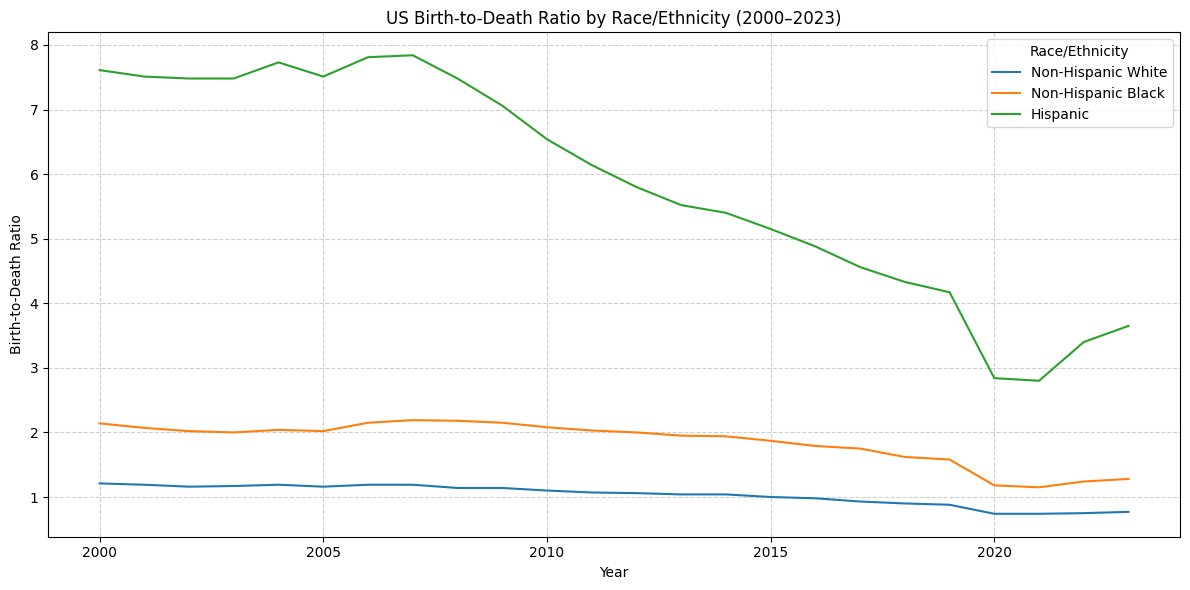

In [5]:
chart = plot_birth_death_ratios()